# Curve fit example using TAU

This folder contains a curve fitting script that will be used for test purposes. This script will first calculate values for Tau. These values will be used by the curve fitting algorithm in order to calculate the most optimal values in a function. The script calculates a couple of different functions, in order to show the possibilities of the algorithm.


## Error of the curve

This script also shows the error of the curve fit, the error shows how far the actual data and the curve fit data are apart from eachother. Their are 4 types of errors shown:

### Max error
The maximum error shows the highest difference between the actual data and the curve fit data at a certain point in the graph.

### Minimum error
The minimum error shows the lowest difference between the actual data and the curve fit data at a certain point in the graph.

### Total error
The total error shows the sum of all the differences between the actual data and the curve fit data.

### Average error
The average error shows the average difference between the actual data and the curve fit data through the entire graph.

### Root mean squared error
This is a indication of how accurate the simulated data is compared to the actual data. This rmse is the most important stat for our curve fitting model

## Calculating Tau
First the Tau needs to be calculated. 

### Importing libaries
A couple of libaries need to be imported in order to calculate the Tau, these will be imported in the code below. 

In [339]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import pylab
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib import pyplot
from scipy.optimize import curve_fit
import scipy
from numpy import sin, arange
import numpy as np
from curveFitAlgorithm import *
from sklearn.metrics import mean_squared_error
#from matplotlib import rc


In [340]:
binnensensoren = ["Windheim_OS11_GRFMET_8", "Windheim_OS8_GRFSYS_22", "Windheim_OS12_GRFMET_8", "Windheim_OS18_GRFMET_8"]
buitensensoren = ["Windheim_OS5_GRFSYS_14"]

### Methods


In [341]:
def get_rawdata(filename = "../../data/x-building/measurements.zip", starttime = '2019-02-01', endtime = '2019-02-02') -> pd.DataFrame:
    """Extract the raw dataset and add a datetime column"""

    raw_df = pd.read_csv(filename)
    raw_df['Systeemtijd'] = pd.to_datetime(raw_df['Systeemtijd'], format='%Y-%m-%d %H:%M:%S')
    
    return raw_df[(raw_df['Systeemtijd'] >= starttime) & (raw_df['Systeemtijd'] <= endtime)]

In [342]:
def parse_sensors(df : pd.DataFrame, sensors : list) -> pd.DataFrame:
    """Generic function to extract specific sensors out of a dataset"""
    
    subset = df.loc[df['Sensor'].isin(sensors)]
    
    pivottable = pd.pivot_table(subset, values=['Waarde'], columns=['Sensor'], index=['Systeemtijd'])
    
    return pivottable

In [343]:
def parse_temperature(df : pd.DataFrame, sensors : list) -> pd.Series:
    """Create a single dataseries for a group of sensors. Data is combined as a median"""
    
    subset = parse_sensors(df, sensors)
        
    return subset.median(axis=1) / 10. 

In [344]:
def getTau(data) -> float:
    """
    tau = (tijd_endcool - tijd_startcool) / ln(temp_vershil_start / tempverschil_end)
    data = dataframe van 1 dag (24h)
    """
    df = data.copy()
    
    timespan = df.index.max() - df.index.min()
    timespan_hours = timespan.seconds / 3600.
        
    temp_in_start = df.loc[df.index.min() == df.index, 'T_in'].values[0]
    temp_out_start = df.loc[df.index.min() == df.index, 'T_out'].values[0]
    temp_in_end = df.loc[df.index.max() == df.index, 'T_in'].values[0]
    temp_out_end = df.loc[df.index.max() == df.index,'T_out'].values[0]

    diff_temp_start = temp_in_start - temp_out_start
    diff_temp_end = temp_in_end - temp_out_start
    tau = ((timespan_hours) / (math.log(diff_temp_start / diff_temp_end)))

    return tau

In [345]:
def filter_data():
    results = {}
    dates = np.unique([i.date().isoformat() for i in df.index])

    i = 0

    for date in dates:
        for hour in range(0,4):
            subset[i] = df.loc[(df.index >= '{0} 00:00:00'.format(date, hour)) & (df.index < '{0} 05:00:00'.format(date, hour+1))].copy()
            i += 1
    
    return subset


### Main
Get the main data

In [346]:
raw_df = get_rawdata()

In [347]:
df = pd.DataFrame()
df['T_in'] = parse_temperature(raw_df, binnensensoren)
df['T_out'] = parse_temperature(raw_df, buitensensoren)
df['T_diff'] = df['T_in'] - df['T_out']

In [359]:
results = {}
dates = np.unique([i.date().isoformat() for i in df.index])
df_filter = df.iloc[0:0]
for date in dates:
    for hour in range(0,4):
        subset = df.loc[(df.index >= '{0} 00:00:02'.format(date, hour)) & (df.index < '{0} 05:00:00'.format(date, hour+1))].copy()
    df_filter = df_filter.append(subset)

df_results = pd.DataFrame(data=results.values(), columns=['tau'], index=results.keys())

In [357]:
#af = filter_data()
af = df_filter

af['timestamp_in_seconds'] = af.index.astype(np.int64)

T_out_interpolated = scipy.interpolate.interp1d(af['timestamp_in_seconds'], af['T_out'])
T_in_interpolated = scipy.interpolate.interp1d(af['timestamp_in_seconds'], af['T_in'])

T_difference_interpolated = lambda t: T_in_interpolated(t) - T_out_interpolated(t)

t = af['timestamp_in_seconds']

### Calculate Tau
Calculate Tau between 00:00:00 and 05:00:00

In [350]:
results = {}
dates = np.unique([i.date().isoformat() for i in df.index])

for date in dates:
    for hour in range(0,4):
        subset = df.loc[(df.index >= '{0} 00:00:02'.format(date, hour)) & (df.index < '{0} 05:00:00'.format(date, hour+1))].copy()
    
    if not subset.empty:
        date = subset.index[0].date().isoformat()

        try:
            tau = getTau(subset)
            results['{0}'.format(date, hour)] = tau
        except ZeroDivisionError:
            tau = np.inf
                
df_results = pd.DataFrame(data=results.values(), columns=['tau'], index=results.keys())

                     T_in  T_out  T_diff  timestamp_in_seconds
Systeemtijd                                                   
2019-02-01 00:00:00   NaN    NaN     NaN                   NaN
2019-02-01 00:08:00   NaN    NaN     NaN                   NaN
2019-02-01 00:16:00   NaN    NaN     NaN                   NaN
2019-02-01 00:24:00   NaN    NaN     NaN                   NaN
2019-02-01 00:32:00   NaN    NaN     NaN                   NaN
...                   ...    ...     ...                   ...
2019-11-30 23:28:00   NaN    NaN     NaN                   NaN
2019-11-30 23:36:00   NaN    NaN     NaN                   NaN
2019-11-30 23:44:00   NaN    NaN     NaN                   NaN
2019-11-30 23:52:00   NaN    NaN     NaN                   NaN
2019-12-01 00:00:00   NaN    NaN     NaN                   NaN

[54070 rows x 4 columns]


## Curve fitting
In this example will we use curve fitting on the calculated tau data

After all Tau values are calculated, curve fitting will be applied in order to calculate the most optimal fit. The code below will calculate a couple of fits using different functions, in order to show a couple of different fits. 


### Import libraries
In order to calculate the most optimal fit for the Tau values a couple of libraries need to be imported. 

In [351]:
import math
import pylab
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib import pyplot
from scipy.optimize import curve_fit
from numpy import sin, arange
import numpy as np
import seaborn as sns

This code will create indexes, that will be used by the curvefit algorithm. These indexes will provide a better overview of the data than using dates as indexes.


In [352]:
def getList(size):
    newIndexes = np.array([0])
    for number in range(size-1):
        newIndexes = np.append(newIndexes, number)
    return newIndexes

The code below shows a couple of different functions that could be used by a curve fitting algorithm. Each function is calculated diffently and will provide various results.  

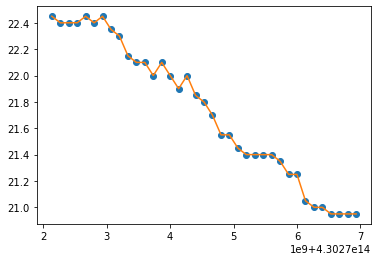

In [353]:
tnew = np.linspace(t.min(), t.max(), 1100)

x = T_difference_interpolated(tnew)
pylab.plot(t/3600, T_difference_interpolated(t), 'o')
pylab.plot(tnew/3600, x)

In [354]:
print(df_results['tau'])

2019-02-01    266.992809
Name: tau, dtype: float64


In [355]:
def T_afgeleide(t, Tin, tau):
    return -(Tin - T_out_interpolated(t)) / tau

def integreer_functie_over_afgeleide(t, tau):
    T = [T_difference_interpolated(t[0])]
    date = pd.to_datetime(t[0]/1000000000, unit='s').date()

    for index in range(1, len(t)):    
        current_date = pd.to_datetime(t[index]/1000000000, unit='s').date()
        
        if date == current_date:
            dt = (t[index]/1000000000) - (t[index-1]/1000000000)
            ystep = T_afgeleide(t[index], T[-1], tau) * dt
            T.append(T[-1] + ystep)
            print(current_date)
        else:
            date = pd.to_datetime(t[0]/1000000000, unit='s').date()
            T.append(T_difference_interpolated(t[index]))

    return T

#
model = scipy.optimize.curve_fit(integreer_functie_over_afgeleide, tnew, x, bounds=([300], [300*3600]))

print("tau:", round(model[0][0]/3600,1), 'hour')




19-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2019-02-01
2

## Sine wave curve fitting

The sine-fit algorithm is a fitting algorithm based on parameter estimation. Sine function signal model is sampled at equal intervals. The least squares method is used to fit the sampling sequence to determine the amplitude, frequency, phase and DC component of the sine-wave, so as to obtain a sine function expression

In [356]:
size = 60
x = getList(size)

y = df_results['tau'].head(size)

curve_fit_algorithm = SineWaveFit(x, y)
y_line = curve_fit_algorithm.get_y_line()
x_line = curve_fit_algorithm.get_x_line()


# plot input vs output
pyplot.scatter(x, y)

# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '-', color='red')
pyplot.show()

print('rmse: ', curve_fit_algorithm.get_rmse())
print('total error: ', curve_fit_algorithm.get_total_error())
print('max error: ', curve_fit_algorithm.get_max_error())
print('min error: ', curve_fit_algorithm.get_min_error())
print('average error: ', curve_fit_algorithm.get_average_error())


ValueError: Found input variables with inconsistent numbers of samples: [1, 60]

## Polynomial regression curve fitting

In statistics, polynomial regression is a form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modelled as an nth degree polynomial in x. Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y, denoted E(y |x). Although polynomial regression fits a nonlinear model to the data, as a statistical estimation problem it is linear, in the sense that the regression function E(y | x) is linear in the unknown parameters that are estimated from the data. For this reason, polynomial regression is considered to be a special case of multiple linear regression.

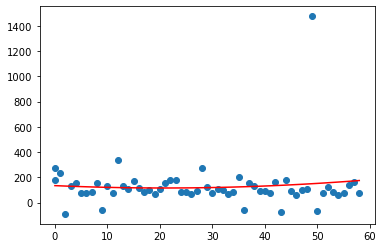

rmse:  190.91368745939795
total error:  4907.117848846252
max error:  1328.4038663695808
min error:  1.0832464435721931
average error:  81.78529748077086


In [13]:
#polynomial regression curve fitting
size = 60
x = getList(size)

y = df_results['tau'].head(size)

curve_fit_algorithm = PolynomialRegressionFit(x, y)
y_line = curve_fit_algorithm.get_y_line()
x_line = curve_fit_algorithm.get_x_line()

# plot input vs output
pyplot.scatter(x, y)

# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '-', color='red')
pyplot.show()

print('rmse: ', curve_fit_algorithm.get_rmse())
print('total error: ', curve_fit_algorithm.get_total_error())
print('max error: ', curve_fit_algorithm.get_max_error())
print('min error: ', curve_fit_algorithm.get_min_error())
print('average error: ', curve_fit_algorithm.get_average_error())

## non-linear least squares curve fitting

Non-linear least squares is the form of least squares analysis used to fit a set of m observations with a model that is non-linear in n unknown parameters (m ≥ n). It is used in some forms of nonlinear regression. The basis of the method is to approximate the model by a linear one and to refine the parameters by successive iterations. 


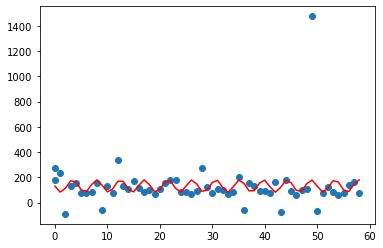

rmse:  188.49521076468054
total error:  4975.078867261613
max error:  1299.1063829084135
min error:  1.9649357652408384
average error:  82.91798112102688


In [14]:
#non-linear least squares curve fitting
size = 60
x = getList(size)

y = df_results['tau'].head(size)

curve_fit_algorithm = NonLinearLeastSquaresFit(x, y)
y_line = curve_fit_algorithm.get_y_line()
x_line = curve_fit_algorithm.get_x_line()

# plot input vs output
pyplot.scatter(x, y)

# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '-', color='red')
pyplot.show()

print('rmse: ', curve_fit_algorithm.get_rmse())
print('total error: ', curve_fit_algorithm.get_total_error())
print('max error: ', curve_fit_algorithm.get_max_error())
print('min error: ', curve_fit_algorithm.get_min_error())
print('average error: ', curve_fit_algorithm.get_average_error())

## Fifth degree polynomial

Fifth degree polynomials are also known as quintic polynomials. Quintics have these characteristics:

* One to five roots.
* Zero to four extrema.
* One to three inflection points.
* No general symmetry.
* It takes six points or six pieces of information to describe a quintic function.

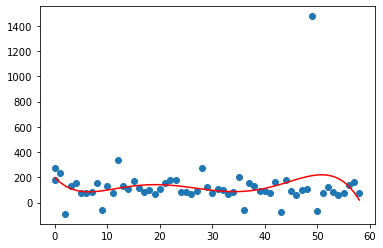

rmse:  186.71832798235968
total error:  5177.152342538546
max error:  1264.3920290399362
min error:  0.4382518936422457
average error:  86.28587237564243


In [15]:
size = 60
x = getList(size)

y = df_results['tau'].head(size) 

curve_fit_algorithm = FifthDegreePolynomialFit(x, y)
y_line = curve_fit_algorithm.get_y_line()
x_line = curve_fit_algorithm.get_x_line()

pyplot.scatter(x, y)

# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '-', color='red')
pyplot.show()

print('rmse: ', curve_fit_algorithm.get_rmse())
print('total error: ', curve_fit_algorithm.get_total_error())
print('max error: ', curve_fit_algorithm.get_max_error())
print('min error: ', curve_fit_algorithm.get_min_error())
print('average error: ', curve_fit_algorithm.get_average_error())

## Linear curve fitting

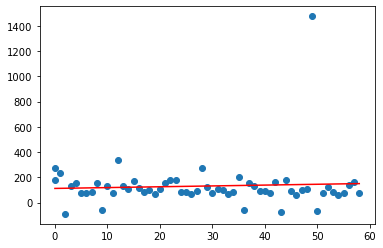

rmse:  191.25605228116123
total error:  4967.476093507766
max error:  1333.5074958912332
min error:  1.9428091462541488
average error:  82.79126822512943


In [16]:

size = 60
x = getList(size)

y = df_results['tau'].head(size)

# plot input vs output
pyplot.scatter(x, y)

curve_fit_algorithm = LinearFit(x, y)
y_line = curve_fit_algorithm.get_y_line()
x_line = curve_fit_algorithm.get_x_line()

# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '-', color='red')
pyplot.show()

print('rmse: ', curve_fit_algorithm.get_rmse())
print('total error: ', curve_fit_algorithm.get_total_error())
print('max error: ', curve_fit_algorithm.get_max_error())
print('min error: ', curve_fit_algorithm.get_min_error())
print('average error: ', curve_fit_algorithm.get_average_error())